In [2]:
import numpy as np
import matplotlib.pyplot as plt
from jax import grad
import jax.numpy as jnp

In [3]:
# [1] Doekemeijer, van der Hoek, van Wingerden, Closed-loop model-based wind farm control
# using FLORIS under time-varying inflow conditions, 2020, Renewable Energy

rho = 1.225 # density of air
D = 178.3  # radius of wind turbine blades; from [1]
A = np.pi*(D/2)**2 # swept area of wind turbine blades
p = 2. # power on yaw angle in power eqn. TO DO: look up real value
a = .2 # max is Betz limit=1/3; Bastankhah has values a=.1 to .33
Cp = 4.*a*(1.-a)**2 
Ct = 4*a*(1-a) # Bastankhah has values .4 to .9 -> a=.1 to .33 (wake deflection larger for larger Ct)

vary_Uinf = False
U_inf = 8. # [1]
T = 100
U_infs = [U_inf]*T
case = '_constant'
if vary_Uinf:
    case = '_varying'
    U_infs = [(U_inf/2.)*(1+np.cos(t*(2*np.pi)/(2*T))) for t in range(T)]

ky = .05 # [1] wake expansion = .02 in Bastankhah

C0 = 1. - np.sqrt(1-Ct)
M0 = C0*(2.-C0)
E0 = C0**2 - 3.*np.exp(1./12.)*C0+3.*np.exp(1./3.)

x0 = 0.*D # [1] 1.088
sigma_z0 = np.sqrt(1./8.)*D 

In [4]:
# location of downstream turbine
X = 6.*D
Y = 0.

# yaw angle
gamma = 0.

# variables that don't change based on u1
sigma_y0 =  sigma_z0*jnp.cos(gamma)
theta = .3*gamma/jnp.cos(gamma)*(1-jnp.sqrt(1-Ct*jnp.cos(gamma)))
delta0 = x0*theta
sigma_y = ky*(X-x0)+sigma_y0
delta_log = jnp.log(((1.6+np.sqrt(M0))*(1.6*jnp.sqrt(sigma_y/sigma_y0)-np.sqrt(M0))) / 
                    ((1.6-np.sqrt(M0))*(1.6*jnp.sqrt(sigma_y/sigma_y0)+np.sqrt(M0))))
delta = delta0 + D*theta*E0/5.2*jnp.sqrt(sigma_y0/(ky*M0))*delta_log
C = 1. - jnp.sqrt(1. - sigma_y0*M0/sigma_y)

# order to match non-jax implementation
def get_u(U1):
    return U1*(1.-C*jnp.exp(-.5*jnp.power((Y-delta)/sigma_y, 2)))

dg2 = grad(get_u)

In [5]:
# get real u1, u2 values (real state always U_inf)
Ny = 2
R = U_inf*.01*np.eye(Ny)

sigma_diff = U_inf*.1
u_diff = np.random.normal(scale=sigma_diff, size=T)
u1 = U_infs + u_diff
u2 = get_u(u1.copy())

# get measurements
mu = np.zeros(Ny)
v = np.random.multivariate_normal(mu, cov=R, size=T)
xs = np.concatenate([np.reshape(u1.copy(), [-1, 1]), np.reshape(u2.copy(), [-1, 1])], axis=1)
ys = xs + v

In [6]:
Nx = 1

Q = U_inf*.01*np.eye(Nx)

mu0 = np.zeros((Nx,1))
Sigma0 = .01*np.eye(Nx)

# steady state wake model; steady state parameter
def get_f(x):
    return x

A = np.eye(Nx)

def get_g(x):
    return np.array([[x[0][0]], [get_u(x[0][0])]])

def get_C(x, Ny):
    C = np.zeros((Ny,1))
    C[0][0] = 1.
    C[1][0] = float(dg2(x[0][0]))
    return C

In [7]:
mu = mu0
Sigma = Sigma0

mus = [mu[0][0]]
Sigmas = [Sigma[0][0]]

for t in range(T):
    # real measurements
    y = np.reshape(ys[t,:], [-1, 1])

    # predict
    mu_temp = get_f(mu)
    Sigma_temp = A@Sigma@A.T+Q

    # update
    Ct = get_C(mu_temp, Ny)
    K = Sigma_temp @ Ct.T @ np.linalg.inv(Ct@Sigma_temp@Ct.T + R)
    mu = mu_temp + K@(y - get_g(mu_temp))
    Sigma = Sigma_temp - K@Ct@Sigma_temp

    mus.append(mu[0][0])
    Sigmas.append(Sigma[0][0])

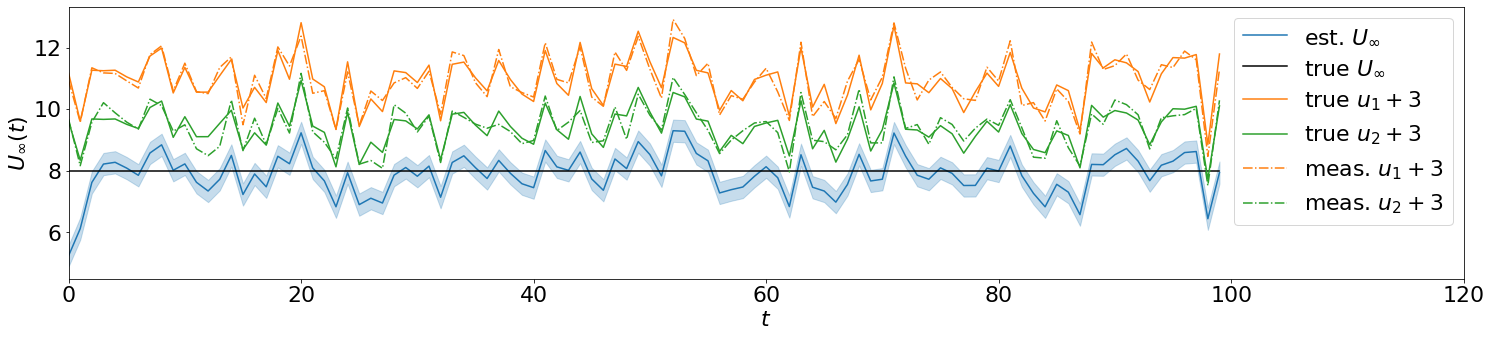

In [12]:
plt.plot(mus[1:], label=r'est. $U_{\infty}$')
# plt.axhline(U_inf, label=r'true $U_{\infty}$', color='k')
plt.plot(U_infs, label=r'true $U_{\infty}$', color='k')
sqrt_sigma=np.sqrt(Sigmas)
t = np.arange(T)
plt.fill_between(t, mus[1:] - 1.96*sqrt_sigma[1:], mus[1:] + 1.96*sqrt_sigma[1:], color='tab:blue', alpha=0.25)
plt.plot([x[0] + 3. for x in xs], label=r'true $u_1 + 3$')
plt.plot([x[1] + 3. for x in xs], label=r'true $u_2 + 3$')
plt.plot([y[0] + 3. for y in ys], label=r'meas. $u_1 + 3$', color='tab:orange', linestyle='-.')
plt.plot([y[1] + 3. for y in ys], label=r'meas. $u_2 + 3$', color='tab:green', linestyle='-.')
plt.xlabel(r'$t$')
plt.ylabel(r'$U_{\infty}(t)$')
plt.xlim([0, T+20])
plt.legend(loc='upper right')
# plt.savefig('U_inf' + case, bbox_inches='tight')
plt.show()

## jax plot field w/ yaw
inputs: x, y, gamma

In [10]:
# define variables
# gamma = cp.Variable() # yaw angle

def get_sigma_y0(gamma):
    return sigma_z0*jnp.cos(gamma)

def get_theta(gamma):
    return .3*gamma/jnp.cos(gamma)*(1-jnp.sqrt(1-C*jnp.cos(gamma)))

def get_delta0(gamma, x0):
    theta = get_theta(gamma)
    return x0*theta

def get_sigma_y(gamma, x, x0):
    sigma_y0 = get_sigma_y0(gamma)
    return ky*(x-x0)+sigma_y0

def get_delta(gamma, x, x0):
    sigma_y = get_sigma_y(gamma, x, x0)
    sigma_y0 = get_sigma_y0(gamma)
    delta_log = jnp.log(((1.6+np.sqrt(M0))*(1.6*jnp.sqrt(sigma_y/sigma_y0)-np.sqrt(M0))) / 
                       ((1.6-np.sqrt(M0))*(1.6*jnp.sqrt(sigma_y/sigma_y0)+np.sqrt(M0))))
    delta0 = get_delta0(gamma, x0)
    theta = get_theta(gamma)
    return delta0 + D*theta*E0/5.2*jnp.sqrt(sigma_y0/(ky*M0))*delta_log

def get_C(gamma, x, x0):
    sigma_y = get_sigma_y(gamma, x, x0)
    sigma_y0 = get_sigma_y0(gamma)    
    return 1. - jnp.sqrt(1. - sigma_y0*M0/sigma_y)

# order to match non-jax implementation
def get_u(x, y, gamma, x0):
    C = get_C(gamma, x, x0)
    delta = get_delta(gamma, x, x0)
    sigma_y = get_sigma_y(gamma, x, x0)
    return U_inf*(1.-C*jnp.exp(-.5*jnp.power((y-delta)/sigma_y, 2)))

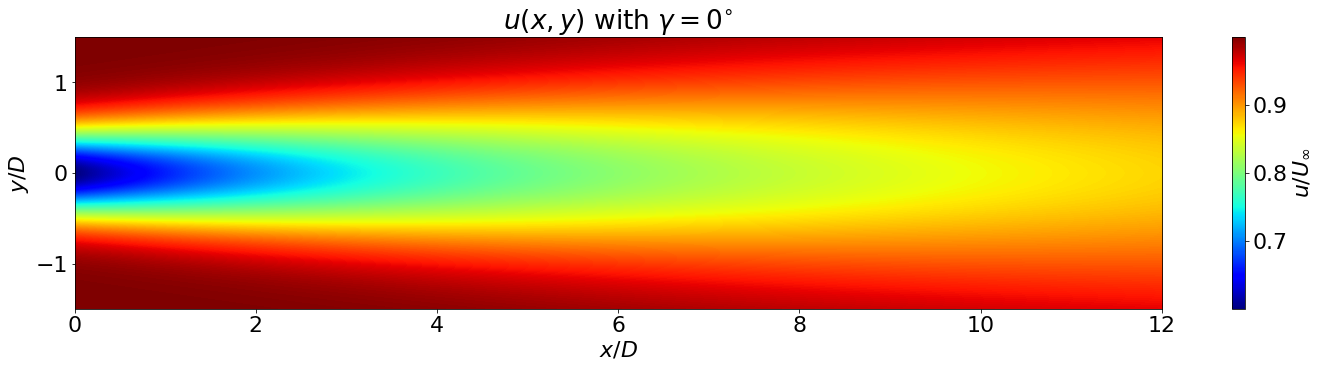

In [11]:
N = 1000
x0 = 0.*D
x_min = x0
x_max = 12*D
x = np.linspace(x_min, x_max, N)
y_min = -1.5*D
y_max = 1.5*D
y = np.linspace(y_min, y_max, N)
   
U1s = []
# gammas = np.pi/180.*np.array([0., 10., 20., 30.])
gammas = np.pi/180.*np.array([0.])
for gamma in gammas:
    U1 = np.zeros((N,N))
    for i in range(N):
        xi = x[i]
        U1[i,:] = np.array(get_u(xi, y, gamma, x0))
    U1s.append(U1)
    
for i in range(len(U1s)):
    U1 = U1s[i]
    gamma = gammas[i]*180./np.pi
    plt.rcParams["figure.figsize"] = (25,5)
    plt.rcParams.update({'font.size': 22})

    plt.imshow(U1.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
    ax=plt.gca()
    ax.invert_yaxis()
    plt.xlabel(r'$x/D$')
    plt.ylabel(r'$y/D$')
    cbar = plt.colorbar()
    cbar.set_label(r'$u/U_{\infty}$')
    plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
#     plt.savefig('flowField_turbine1', bbox_inches='tight')
    plt.show()

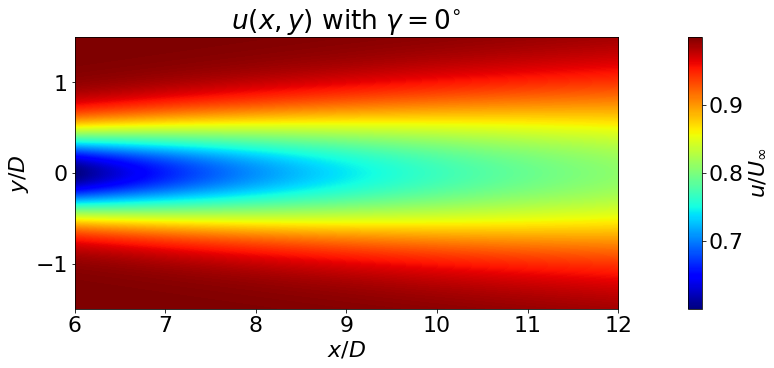

In [13]:
x0 = X
x_min = x0
x_max = 12*D
x = np.linspace(x_min, x_max, int(N/2))
y_min = -1.5*D
y_max = 1.5*D
y = np.linspace(y_min, y_max, N)

U2s = []
# gammas = np.pi/180.*np.array([0., 10., 20., 30.])
gammas = np.pi/180.*np.array([0.])
for gamma in gammas:
    # for plotting
    U2 =np.zeros((int(N/2),N))
    for i in range(int(N/2)):
        xi = x[i]
        U2[i,:] = np.array(get_u(xi, y, gamma, x0))
    U2s.append(U2)
    
for i in range(len(U2s)):
    U2 = U2s[i]
    gamma = gammas[i]*180./np.pi
    plt.rcParams["figure.figsize"] = (25,5)
    plt.rcParams.update({'font.size': 22})

    plt.imshow(U2.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
    ax=plt.gca()
    ax.invert_yaxis()
    plt.xlabel(r'$x/D$')
    plt.ylabel(r'$y/D$')
    cbar = plt.colorbar()
    cbar.set_label(r'$u/U_{\infty}$')
    plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
#     plt.savefig('flowField_turbine2', bbox_inches='tight')
    plt.show()

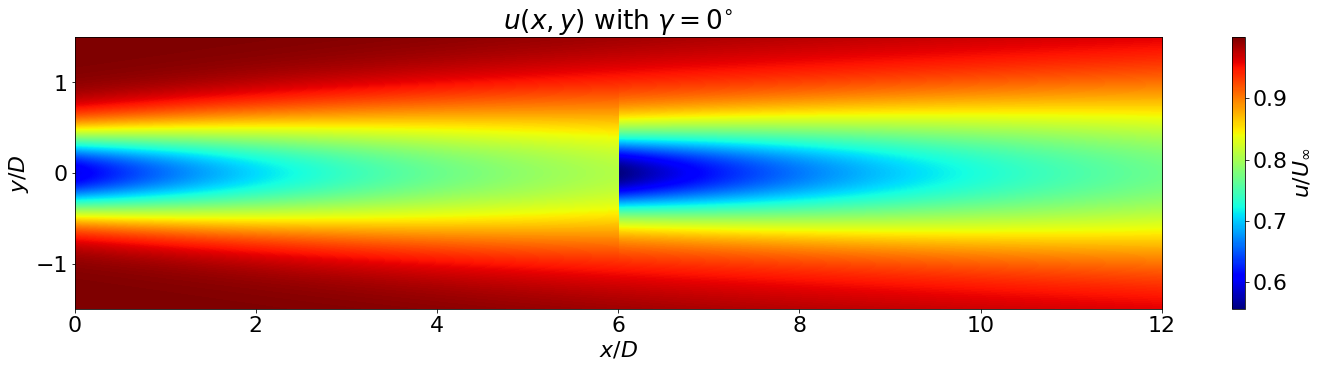

In [497]:
x0 = 0.*D
x_min = x0
x_max = 12*D
x = np.linspace(x_min, x_max, N)
y_min = -1.5*D
y_max = 1.5*D
y = np.linspace(y_min, y_max, N)

U_tot = np.zeros((N,N))
U_tot[:500,:] = U1[:500,:]
U_tot[500:,:] = U_inf*(1.-np.sqrt((1.-U1[500:,:]/U_inf)**2 + (1.-U2/U_inf)**2))

gamma = 0.
plt.rcParams["figure.figsize"] = (25,5)
plt.rcParams.update({'font.size': 22})

plt.imshow(U_tot.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
ax=plt.gca()
ax.invert_yaxis()
plt.xlabel(r'$x/D$')
plt.ylabel(r'$y/D$')
cbar = plt.colorbar()
cbar.set_label(r'$u/U_{\infty}$')
plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
plt.savefig('flowField_twoTurbines', bbox_inches='tight')
plt.show()